# Refine Feature Groups into Final Bins

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [56]:
import jax.numpy as jnp
import jax

In [4]:
from zotbin.group import load_groups
from zotbin.reweight import reweighted_metrics
from zotbin.binned import load_binned

In [5]:
zedges, fedges, grpidw, zhistw, zsimw = load_groups('groups_20_120_200.npz')

In [6]:
zedges, fedges, grpidn, zhistn, zsimn = load_groups('groups_20_120_200_nowgt.npz')

In [7]:
init_data = load_binned('binned_40.npz')

In [8]:
# Need to include zedges in the load_groups result.
assert (len(zedges) - 1) % (len(init_data[0]) - 1) == 0
downsampling = (len(zedges) - 1) // (len(init_data[0]) - 1)
print(f'Downsampling by {downsampling}')

Downsampling by 3


In [9]:
def get_score(group_weights, zhist, gals_per_arcmin2=20., fsky=0.25, metric='FOM_DETF_3x2'):
    # Calculate the redshift distribution in each output bin.
    ngrp, nzbin = zhist.shape
    nbin = len(group_weights)
    assert group_weights.shape[1] == ngrp
    zhist_out = group_weights.dot(zhist)
    # Downsample to the redshift binning used for fast reweighted scores.
    zhist_ds =  zhist_out.reshape(nbin, nzbin // downsampling,  downsampling).sum(axis=-1)
    # Calculate the corresponding weights to use.
    w = zhist_ds / zhist.sum()
    # Calculate the metrics for these weights.
    weights = jnp.array([w,  w])
    scores = reweighted_metrics(weights, *init_data[1:], gals_per_arcmin2=gals_per_arcmin2, fsky=fsky, metrics=[metric])
    return scores[metric]

## Method 1

Keep the groups in their mean-redshift sorted order and find the breakpoints with the maximum score using an exhaustive search:

In [13]:
def method1_weights(*breaks, zhist=None):

    ngrp, nzbin = zhist.shape
    nbin = len(breaks) + 1
    w = np.zeros((nbin, ngrp))
    breaks = np.concatenate(([0], breaks, [ngrp]))
    assert np.all(np.diff(breaks) > 0)
    igrp = np.arange(ngrp)
    for i in range(nbin):
        sel = (breaks[i] <= igrp) & (igrp < breaks[i + 1])
        w[i, sel] = 1.
    return w

In [50]:
def iter_breaks(ngrp, nbin):
    assert nbin >= 2 and nbin <= 5
    for i1 in range(1, ngrp - nbin):
        if nbin == 2:
            yield [i1]
            continue
        for i2 in range(i1 + 1, ngrp - nbin + 1):
            if nbin == 3:
                yield [i1, i2]
                continue
            for i3 in range(i2 + 1, ngrp - nbin + 2):
                if nbin == 4:
                    yield [i1, i2, i3]
                    continue
                for i4 in range(i3 + 1, ngrp - nbin + 3):
                    yield [i1, i2, i3, i4]

In [51]:
def method1_optimize(nbin=2, zhist=None):
    scores = []
    breaks = []
    ngrp, nzbin = zhist.shape
    for brk in iter_breaks(ngrp, nbin):
        breaks.append(brk)
        w = method1_weights(*brk, zhist=zhist)
        scores.append(float(get_score(w, zhist=zhist)))
    plt.plot(scores)
    plt.show()
    ibest = np.argmax(scores)
    print(f'Best breaks are {breaks[ibest]} with score = {scores[ibest]}.')
    wbest =  method1_weights(*breaks[ibest], zhist=zhist)
    zc = 0.5 * (zedges[1:] + zedges[:-1])
    dndz =  wbest.dot(zhist)
    for i in range(nbin):
        plt.plot(zc, dndz[i])
    plt.xlabel('Redshift $z$')
    plt.yticks([])
    plt.xlim(zedges[0], zedges[-1])
    plt.ylim(0, None)

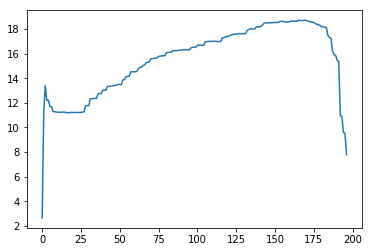

Best breaks are [171] with score = 18.72217559814453.
CPU times: user 18.4 s, sys: 695 ms, total: 19.1 s
Wall time: 17.9 s


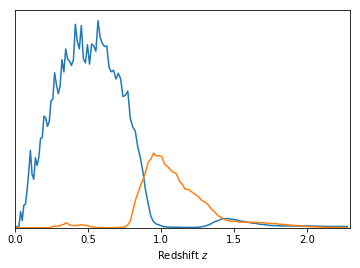

In [52]:
%time method1_optimize(nbin=2, zhist=zhistw)

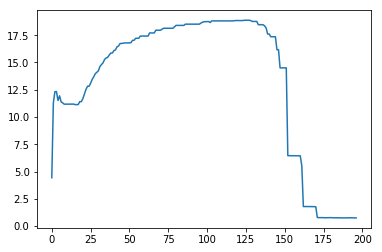

Best breaks are [128] with score = 18.873262405395508.
CPU times: user 18.4 s, sys: 563 ms, total: 18.9 s
Wall time: 17.8 s


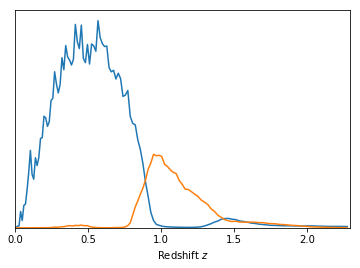

In [53]:
%time method1_optimize(nbin=2, zhist=zhistn)

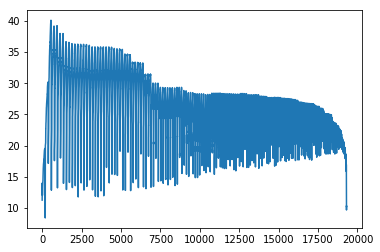

Best breaks are [3, 171] with score = 40.1136589050293.
CPU times: user 37min 16s, sys: 58 s, total: 38min 14s
Wall time: 36min 5s


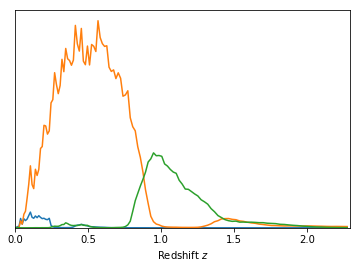

In [54]:
%time method1_optimize(nbin=3, zhist=zhistw)

## Method 2

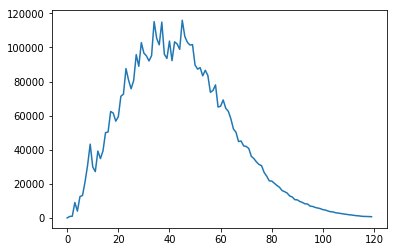

In [11]:
plt.plot(zhistw.sum(axis=0));

In [60]:
import flax.optim

0 -48.30510330200195
1 -48.30510330200195
2 -48.30510330200195
3 -48.30510330200195
4 -48.30510330200195
5 -48.30510330200195
6 -48.30510330200195
7 -48.30510330200195
8 -48.30510330200195
9 -48.30510330200195


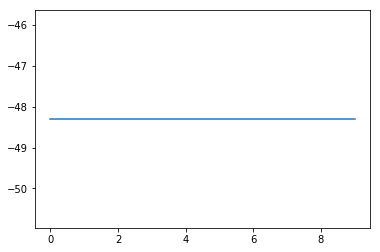

In [63]:
def method2_optimize(nbin=2, zhist=zhistw, gals_per_arcmin2=20., fsky=0.25, metric='FOM_DETF_3x2'):

    ngrp, nzbin = zhist.shape
    
    # Calculate the normalized n(z) for all galaxies.
    nds = nzbin // downsampling
    nofz = jnp.array(zhist.sum(axis=0).reshape(nds, downsampling).sum(axis=1))
    nofz /= nofz.sum()
    
    ##nofz /= nofz.sum()
    # Initialize weights for equal bin contents.
    cdf = np.cumsum(nofz)
    cdf = np.concatenate(([0], cdf)) / cdf[-1]
    s = np.linspace(0, 1, nbin + 1)
    brk = np.interp(s, cdf, np.arange(nds + 1))
    w = np.zeros((nbin, nds))
    x = np.arange(nds)
    for i in range(nbin):
        sel = (x >= brk[i]) & (x < brk[i + 1])
        w[i, sel] = 5.
    p = jnp.array(w - w.sum(axis=0) / nbin)
    
    @jax.jit
    def loss(p):
        w = jnp.exp(p)
        w /= w.sum(axis=0)
        w *= nofz
        psum = p.sum(axis=0)
        weights = jnp.array([w,  w])
        return -reweighted_metrics(weights, *init_data[1:], gals_per_arcmin2=gals_per_arcmin2, fsky=fsky, metrics=[metric])[metric]
        
    value_and_loss = jax.jit(jax.value_and_grad(loss))
    
    eta = 0.5
    niter = 10
    losses = []
    # I don't think there is an easy way to use the built-in optimizers without defining a nn.Module subclass.
    #opt = flax.optim.Adam(learning_rate=eta).create(p)
    for it in range(niter):
        loss, grads = value_and_loss(p)
        p = p - eta * grads
        losses.append(float(loss))
        if it % 10 == 0:
            print(it, losses[-1])
        
    plt.plot(losses)
    plt.show()
    
    
    
method2_optimize(nbin=5)